In [5]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
from utils.img_utils import *
from testing.test_dataset import *
from dataio.MimicCXRDataset import train_test_split_CXR
from hydra import initialize, initialize_config_module, initialize_config_dir, compose

with initialize(version_base=None, config_path="../configs"):
       cfg = compose(config_name="dataset_config")

print("running config:",cfg)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
running config: {'root_dir': '/Users/ago/PycharmProjects/mml/data/mimic-cxr-preprocessed', 'class_names': ['No Finding'], 'trans_resize': 224, 'view_position': 'PA', 'splitting': {'method': 'random', 'train_val_split': 0.6, 'test_val_split': 0.5}, 'seed': 42, 'uncertain_values': 'exclude'}


## Verify splits

In [3]:
train_dict, test_dict, val_dict = train_test_split_CXR(cfg)

Root dir:  /Users/ago/PycharmProjects/mml/data/mimic-cxr-preprocessed
Image matrix shape:  (43082, 224, 224)
Number of metadata rows:  43082
Dropping readings with uncertain values in selected class names
Number of filtered metadata rows:  43082
Number of patients in the training set:  25849
Number of patients in the val set:  8617
Number of patients in the test set:  8616
Number of images in train set:  25849
Number of images in val set:  8617
Number of images in test set:  8616


In [4]:
run_test(train_dict['dicom_ids'], test_dict['dicom_ids'], val_dict['dicom_ids'])
run_test(train_dict['ids'], test_dict['ids'], val_dict['ids'])

No overlapping splits found.
Test passed.
No overlapping splits found.
Test passed.


In [180]:

# describe train, test, val datasets
print("train set description", train_dict['labels'].fillna(0).describe())
print("test set description", test_dict['labels'].fillna(0).describe())
print("val set description", val_dict['labels'].fillna(0).describe())

train set description          No Finding
count  25849.000000
mean       0.625131
std        0.484099
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
test set description         No Finding
count  8617.000000
mean      0.624811
std       0.484200
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000
val set description         No Finding
count  8616.000000
mean      0.623143
std       0.484627
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000


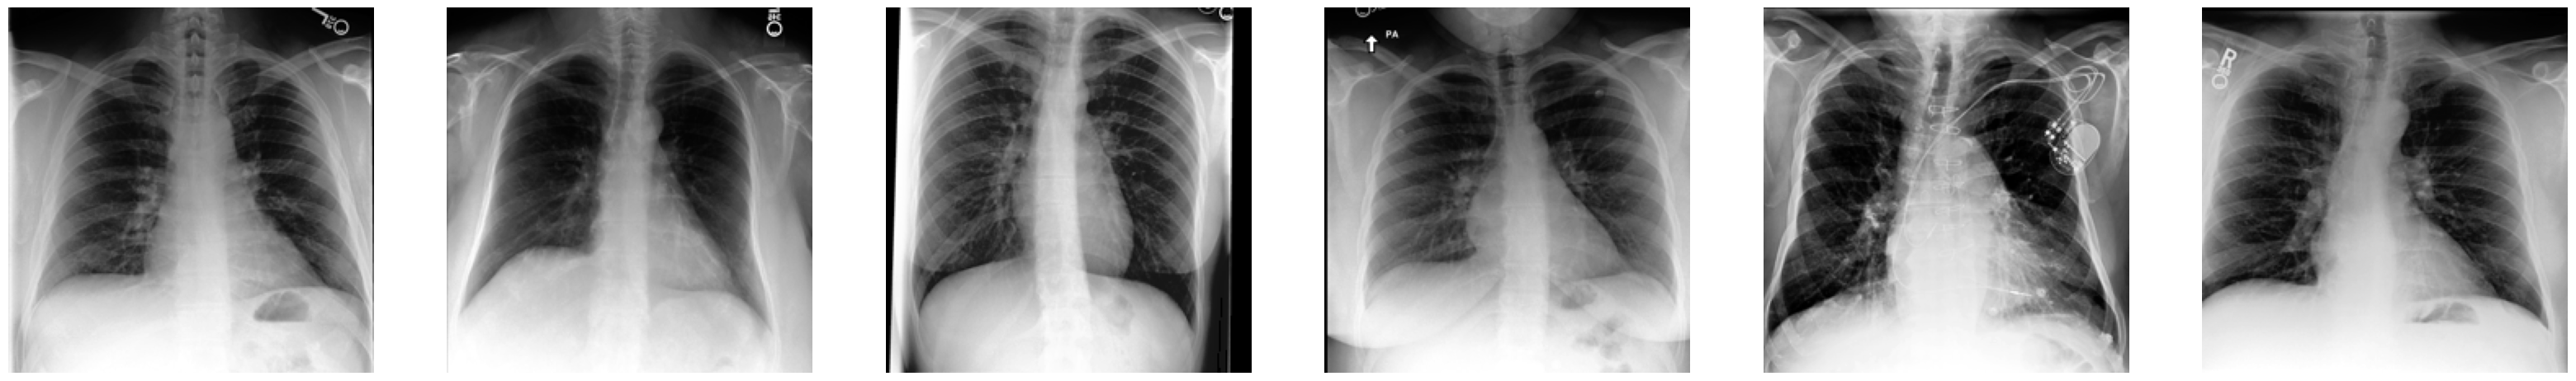

In [181]:
# plot images with target labels = 1
idx, el = np.where(train_dict['labels'].fillna(0).astype(int) == 1)
plot_n_imgs(imgs=train_dict['images'][idx][101:107],n_cols=6,n_rows=1, size=(40,40))

In [182]:
train_dict['labels'].fillna(0).astype(int)


,No Finding
0,0
1,0
2,0
3,1
4,0
...,...
25844,0
25845,0
25846,1
25847,1


In [183]:
idx

array([    3,     5,     6, ..., 25846, 25847, 25848])

In [184]:
train_dict['dicom_ids'][idx]

3        2d8a8525-19d0c810-045e1619-ef196132-cd4f1710
5        3c659977-44aefeb8-cdc200a8-24ea059e-9dd6758c
6        2833b85f-3bb4273f-cffd3794-2bf2cd57-7ddb3f5f
8        e45d57af-62690e1a-9bdf2d66-d10e02de-e9794fc4
9        25423a5e-8c27af51-c2c840f3-b498f42b-8ef8e461
                             ...                     
25842    cc7bd181-f1406934-d058271e-34b1d2f4-cfda1cdd
25843    826b4469-6017264c-2ddd12e8-2e3e5c4c-fe2817bd
25846    4750f069-a4a2b152-61dadb2b-8e7c09a6-1c0578c2
25847    8dc9f5e1-14887015-8db378ef-2fd4441a-d45ee0f3
25848    428e2c18-5721d8f3-35a05001-36f3d080-9053b83c
Name: dicom_id, Length: 16159, dtype: object

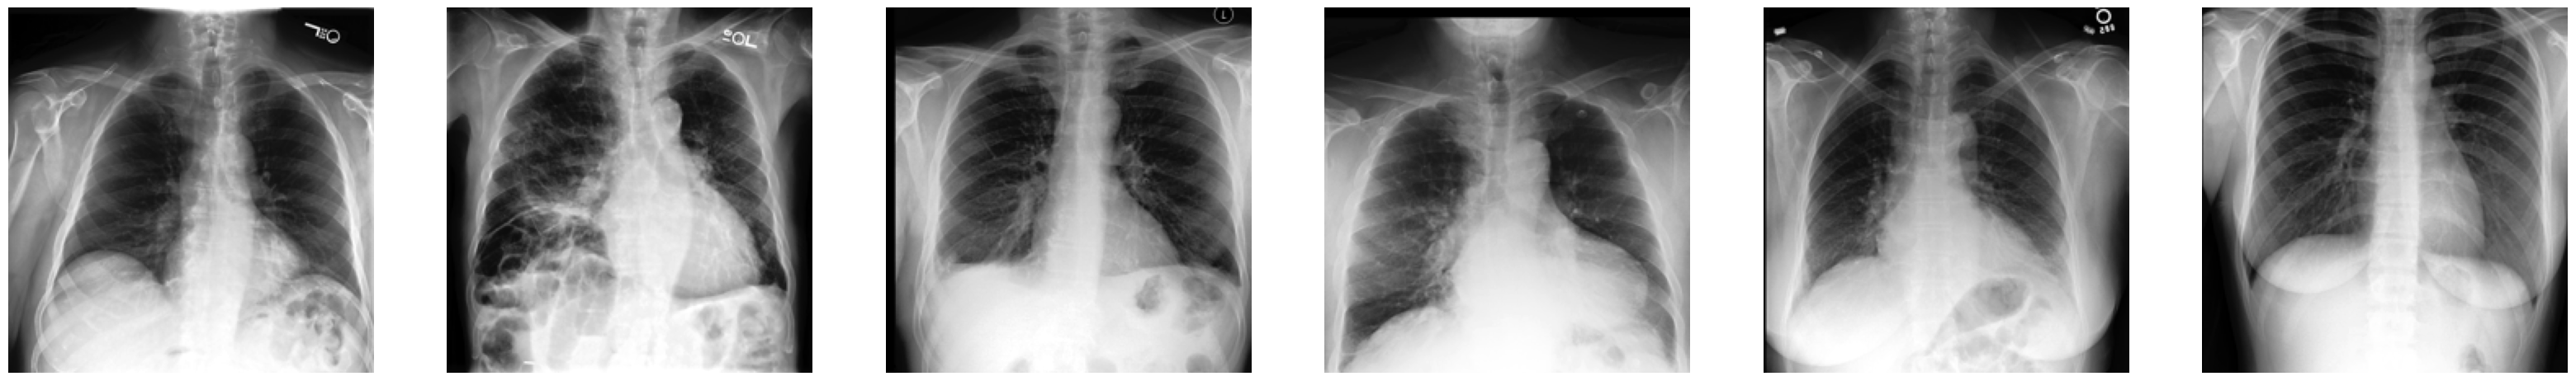

In [185]:
# plot images with target labels = 0
idx, el = np.where(train_dict['labels'].fillna(0).astype(int) == 0)
plot_n_imgs(imgs=train_dict['images'][idx][101:107],n_cols=6,n_rows=1, size=(40,40))

In [186]:
train_dict['dicom_ids'][idx]

0        f1adcae3-2921c0a8-5d9652f9-4191ecd7-f2a96f35
1        925b9496-a956d7b2-05185e52-bb33313b-c06ee522
2        ed9c0dfc-ea25b576-0f8cc069-df4cdf14-0cd60eb7
4        ab37274f-b4c1fc04-e2ff24b4-4a130ba3-cd167968
7        d5fc1956-e9a3e73b-3bc726aa-db2717c4-5905815c
                             ...                     
25838    87923de8-5595ad44-eaa89d38-610e97e2-42cacf04
25840    caf5ea1f-33cfc639-03813873-00c6b0e4-a0651091
25841    a06c18fa-0be7ccf1-5b99ff5c-429949f2-86361e99
25844    9c390b59-c804f98f-d294205c-60530957-c8107dac
25845    12fad032-cf4eff00-32a4fc65-67e424b6-a2e42afb
Name: dicom_id, Length: 9690, dtype: object

# Verify dataset

filling nan with zeros is a good idea? -> example index 101 training set


In [187]:
from dataio.MimicCXRDataset import CXRDataset
from torchvision import transforms


transformList = [transforms.RandomAffine(degrees=(0, 5), translate=(0.05, 0.05), shear=(5)),
                 transforms.RandomHorizontalFlip(), transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
transform = transforms.Compose(transformList)

#transform = transforms.Compose([
    # you can add other transformations in this list
#    transforms.ToTensor()
#])
train_dataset = CXRDataset(label_name=cfg.class_names[0],labels_df=train_dict['labels'],images=train_dict['images'],transform=transform)

In [188]:
image, label = train_dataset.__getitem__(101) #check 101
print(f'label:{label}')

label:1.0


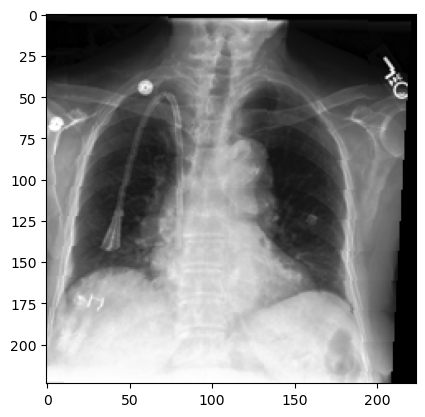

In [189]:
# plot image
plt.imshow(image[0], cmap='gray')

In [190]:
train_dict['dicom_ids'][101]

'efe8834c-2f3e9afb-011c86bc-4506aff3-204a3256'

In [191]:
train_dict['labels'].iloc[101]


No Finding    1.0
Name: 101, dtype: float64

# Verify dataloader


In [194]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


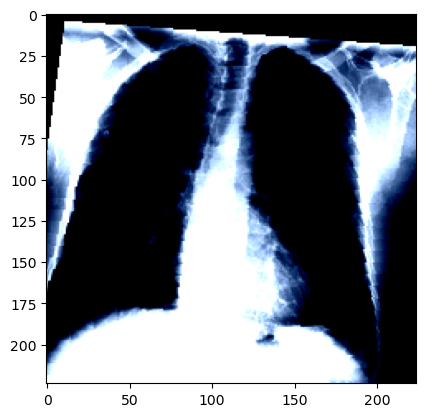

Label: 1.0


In [195]:
# Display image and label.
while label == 0:
       train_features, train_labels = next(iter(train_dataloader))
       print(f"Feature batch shape: {train_features.size()}")
       print(f"Labels batch shape: {train_labels.size()}")
       img = train_features[0].squeeze().permute(1,2,0)
       label = train_labels[0]
       plt.imshow(img, cmap="gray")
       plt.show()
       print(f"Label: {label}")
label = 0